<h1><strong>Modelos de Machine Learning Aplicados ao Mercado Financeiro</strong></h1>
<h4><strong>RESUMO</strong></h4>
<p align="justify">&emsp;O mercado financeiro tem recebido muita atenção recentemente visto que ele tem se apresentado como uma oportunidade para investidores e empresas. Dentre a grande variedade de ativos financeiros pertencentes a este mercado, ações ganham destaque. A previsão do comportamento de ativos, como ações, em janelas curtas de tempo é de grande interesse para operadores, investidores e desenvolvedores de sistemas de apoio à decisão e é neste contexto em que este projeto se insere.</p>
<br>
<p align="justify">&emsp;Neste projeto será desenvolvido em sistema preditivo o de curto prazo (5 minutos à frente) para o mercado financeiro em tempo real utilizando Redes Neurais Recorrentes (SimpleRNN e LTSM). Este sistema será capaz de prever a tendência de preços de ativos, com simulação gráfica em tempo real das previsões e avaliação rigorosa por métricas padronizadas. O intervalo utilizado para treinamento da rede é de 8 dias até o momento atual, sendo o modelo calibrada com janelas de 1 minuto.</p>
<br>
<hr>

<h4><strong>ÍNDICE</strong></h4>
<a href="#1">1. Base de Dados</a>
<br>
<a href="#2">2. Simple Recurrent Neural Networks (SimpleRNN)</a>
<br>
&emsp;<a href = "#2.1">2.1 Dataset Cru</a>
<br>
&emsp;<a href = "#2.2">2.2 Dataset com Ruído</a>
<br>
&emsp;<a href = "#2.3">2.3 Resultados do Treinamento</a>
<br>
&emsp;<a href = "#2.4">2.4 Predição em Tempo Real</a>
<br>
<a href="#3">3. Long Short-Term Memory (LSTM)</a>
<br>
&emsp;<a href = "#3.1">3.1 Dataset Cru</a>
<br>
&emsp;<a href = "#3.2">3.2 Dataset com Ruído</a>
<br>
&emsp;<a href = "#3.3">3.3 Resultados do Treinamento</a>
<br>
&emsp;<a href = "#3.4">3.4 Predição em Tempo Real</a>
<br><br>
<hr>

<h4><strong>BASE DE DADOS</strong></h4>
<a id="1"></a>

In [548]:
# -- INTALAÇÃO DE BIBLIOTÉCAS NECESSÁRIAS --
# !pip install yfinance
# !pip install tensorflow
# !pip install keras
# !pip install pandas
# !pip install matplotlib.pyplot

In [549]:
import yfinance as yf

# -- ADIQUIRINDO ACESSO AS INFORMAÇÕES DA AÇÃO --
# Lista de tickets de ações a serem utilizadas
acao = "VALE3.SA"

# Adquirindo e tratando os valores das ações
data = yf.download( tickers = acao, period = "8d", interval = "1m", auto_adjust = True, ignore_tz = True )
data.dropna( inplace = True ) # removendo valores nulos
display( data[ "Close" ] )
dt = data.index # salvando as datas e o tempo para visualização
data = data[ "Close" ].values # mantendo apenas os valores dos dados de fechamento (o valor no momento em que o registro foi feito)

[*********************100%***********************]  1 of 1 completed


Ticker,VALE3.SA
Datetime,
2025-07-02 10:03:00,53.930000
2025-07-02 10:04:00,54.040001
2025-07-02 10:05:00,54.049999
2025-07-02 10:06:00,54.080002
2025-07-02 10:07:00,54.020000
...,...
2025-07-11 16:50:00,56.000000
2025-07-11 16:51:00,55.990002
2025-07-11 16:52:00,55.990002


In [550]:
import random as rnd
import numpy as np

# -- SEPARANDO E TRATANDO OS DADOS --
n_minutos_frente = 5 # minutos à serem previsto

# Calculando o último minuto multiplo de 5 (e 5 minutos atrasados para exibição)
min, hr = int( dt[ -1 ].strftime( "%M" ) ) // 5, int( dt[ -1 ].strftime( "%H" ) )
minutes = min * 5
if minutes == 0:
  minutes = 60 - 5
  hour = hr - 1
else:
  minutes = minutes - 5
  hour = hr

# Adquirindo o index da data e hora do minuto calculado
if minutes < 10:
  index_5m = list( dt.strftime( "%m/%d/%Y, %H:%M" ) ).index( f"{ dt[ -1 ].strftime( '%m/%d/%Y' ) }, { hour }:0{ minutes }" ) # adicionamoes um 0 (zero) antes do valor do minuto
else:
  index_5m = list( dt.strftime( "%m/%d/%Y, %H:%M" ) ).index( f"{ dt[ -1 ].strftime( '%m/%d/%Y' ) }, { hour }:{ minutes }" )

# Mantendo apenas os dados até o data, hora e minuto calculado
datetimes = dt[ :index_5m + 1 ]

# Criando as variáções do dataset
data_raw = data[ :index_5m + 1 ]
data_noise = list()
for i in data_raw:
  data_noise.append(i + rnd.gauss(0, 0.1))
data_noise = np.array( data_noise )
print( f"Último momento considerado para o treinamento/teste: { dt[ index_5m ] }" )

Último momento considerado para o treinamento/teste: 2025-07-11 16:45:00


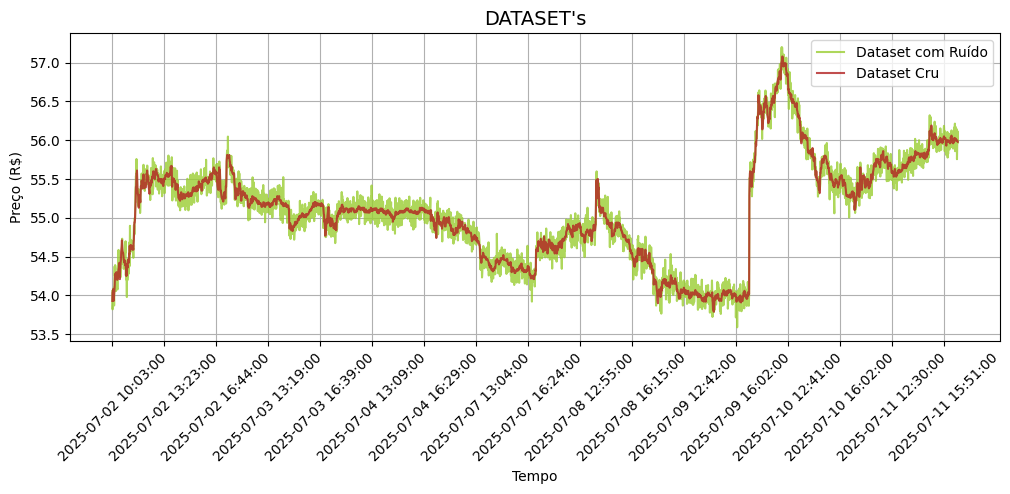

In [551]:
import matplotlib.pyplot as plt

# Exibição dos Diferentes Dataset's
janela_visualizacao = len(data_raw)
tick_indices = range( 0, len( datetimes[ -janela_visualizacao - 1 : ] ), 200)
tick_labels = list( datetimes[ -janela_visualizacao - 1 : : 200] )
plt.rcParams[ "figure.figsize" ] = ( 12, 4 )
plt.plot( data_noise, label = 'Dataset com Ruído', alpha = 0.8, color = 'yellowgreen' )
plt.plot( data_raw, label = 'Dataset Cru', alpha = 0.8, color = 'firebrick' )
plt.title( f"DATASET's", fontsize = 14 )
plt.xlabel( "Tempo" )
plt.xticks( tick_indices, tick_labels, rotation = 45 )
plt.ylabel( "Preço (R$)" )
plt.legend()
plt.grid( True )
plt.show()

<br><hr>

<h4><strong>2. SIMPLE RNN</strong></h4>
<a id="2"></a>

In [552]:
from sklearn.preprocessing import MinMaxScaler

# -x- FUNÇÃO PARA A CRIAÇÃO DAS JANELAS DESLIZANTES DE DADOS -x-
def create_dataset( series, janela = 10 ):
  X, y = [], []
  for i in range( 0, len( series ) - janela ):
    X.append( series[ i : i + janela ] )
    y.append( series[ i + janela ] )
  return np.array( X ), np.array( y )

# -x- CRIANDO E SEPARANDO OS DADOS DE TREINO/TESTE -x-
# Divisão treino/teste
train_size = int( 0.8 * len( data_raw ) )
train_data, test_data = data_raw[ : train_size ], data_raw[ train_size : ]
train_data_noise, _ = data_noise[ : train_size ], data_noise[ train_size : ]

# Normalização dos dados
scaler = MinMaxScaler( feature_range = ( 0, 1 ) )
train_data = scaler.fit_transform( train_data.reshape( -1, 1 ) )
test_data = scaler.transform( test_data.reshape( -1, 1 ) )
train_data_noise = scaler.fit_transform( train_data_noise.reshape( -1, 1 ) )

<h5><strong>2.1 Dataset Cru</strong><h5>
<a id="2.1"></a>
Após um GridSearch, chegamos aos parâmetros:
<br>
num_layers = 1
<br>
janela = 10
<br>
hidden = 64
<br>
activation = relu
<br>
batch_size = 16

In [553]:
# -x- CRIAÇÃO DAS JANELAS -x-
window_size = 10
ws_raw = window_size
X_train, y_train = create_dataset( train_data, window_size )
X_test, y_test = create_dataset( test_data, window_size )

In [554]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# -x- CRIAÇÃO DO MODELO -x-
model_raw_SimpleRNN = Sequential()
model_raw_SimpleRNN.add( SimpleRNN( units = 64, activation = "relu", input_shape = ( window_size, 1 ) ) )
model_raw_SimpleRNN.add( Dense( units = 1 ) )
model_raw_SimpleRNN.compile( optimizer = "adam", loss = "mean_squared_error" )
# Treinamento do modelo
model_raw_SimpleRNN.fit( X_train, y_train, epochs = 100, batch_size = 16, verbose = 0 )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [555]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -x- CALCULO DOS RESULTADOS -x-
# Previsões e inversão da normalização
y_pred_raw = scaler.inverse_transform( model_raw_SimpleRNN.predict( X_test ) )
y_real = scaler.inverse_transform( y_test )

# Cálculo das métricas
mse_raw = mean_squared_error( y_real, y_pred_raw )
rmse_raw = np.sqrt( mse_raw )
mae_raw = mean_absolute_error( y_real, y_pred_raw )
r2_raw = r2_score( y_real, y_pred_raw )

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<h5><strong>2.2 Dataset com Ruído</strong><h5>
<a id="2.2"></a>
Após um GridSearch, chegamos aos parâmetros:
<br>
num_layers = 2
<br>
janela = 20
<br>
hidden1 = 128
<br>
hidden2 = 256
<br>
activation = relu
<br>
batch_size = 64

In [556]:
# -x- CRIAÇÃO DAS JANELAS -x-
window_size = 20
ws_noise = window_size
X_train, y_train = create_dataset( train_data_noise, window_size )
X_test, y_test = create_dataset( test_data, window_size )

In [557]:
# -x- CRIAÇÃO DO MODELO -x-
model_noise_SimpleRNN = Sequential()
model_noise_SimpleRNN.add( SimpleRNN( units = 128, activation = "relu", return_sequences = True, input_shape = ( window_size, 1 ) ) )
model_noise_SimpleRNN.add( SimpleRNN( units = 256, activation = "relu" ) )
model_noise_SimpleRNN.add( Dense( units = 1 ) )
model_noise_SimpleRNN.compile( optimizer = "adam", loss = "mean_squared_error" )
# Treinamento do modelo
model_noise_SimpleRNN.fit( X_train, y_train, epochs = 100, batch_size = 64, verbose = 0 )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [558]:
# -x- CALCULO DOS RESULTADOS -x-
# Previsões e inversão da normalização
y_pred_noise = scaler.inverse_transform( model_noise_SimpleRNN.predict( X_test ) )
y_real = scaler.inverse_transform( y_test )
# Cálculo das métricas
mse_noise = mean_squared_error( y_real, y_pred_noise )
rmse_noise = np.sqrt( mse_noise )
mae_noise = mean_absolute_error( y_real, y_pred_noise )
r2_noise = r2_score( y_real, y_pred_noise )

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


<h5><strong>2.3 Resultados do Treino</strong><h5>
<a id="2.3"></a>

MÉTRICAS SimpleRNN
Dataset Cru
MSE  : 0.00153
RMSE : 0.03916
MAE  : 0.02803
R²   : 0.98385
Dataset com Ruído
MSE  : 0.00754
RMSE : 0.08682
MAE  : 0.07557
R²   : 0.91132


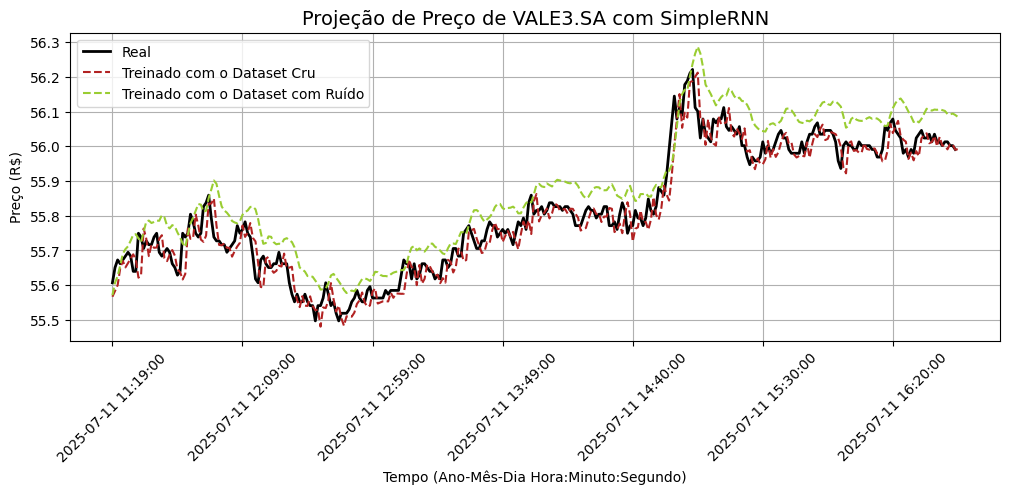

In [559]:
# -x- EXIBIÇÃO DOS RESULTADOS -x-
# Resultados numéricos
print( "MÉTRICAS SimpleRNN" )
print( "Dataset Cru" )
print( f"MSE  : {mse_raw:.5f}" )
print( f"RMSE : {rmse_raw:.5f}" )
print( f"MAE  : {mae_raw:.5f}" )
print( f"R²   : {r2_raw:.5f}" )
print( "Dataset com Ruído" )
print( f"MSE  : {mse_noise:.5f}" )
print( f"RMSE : {rmse_noise:.5f}" )
print( f"MAE  : {mae_noise:.5f}" )
print( f"R²   : {r2_noise:.5f}" )

# Visualização
janela_visualizacao = len(test_data)//2
plt.rcParams[ "figure.figsize" ] = ( 12, 4 )
tick_indices = range( 0, len( datetimes[ -janela_visualizacao - 1 : ] ), 50)
tick_labels = list( datetimes[ -janela_visualizacao - 1 : : 50] )
plt.plot( y_real[ - janela_visualizacao : ], label = 'Real', linewidth = 2, color = 'black' )
plt.plot( y_pred_raw[ - janela_visualizacao : ], label = 'Treinado com o Dataset Cru', linestyle = '--', color = 'firebrick' )
plt.plot( y_pred_noise[ - janela_visualizacao : ], label = 'Treinado com o Dataset com Ruído', linestyle = '--', color = 'yellowgreen' )
plt.title( f"Projeção de Preço de { acao } com SimpleRNN", fontsize = 14 )
plt.xticks( tick_indices, tick_labels, rotation = 45 )
plt.xlabel( "Tempo (Ano-Mês-Dia Hora:Minuto:Segundo)" )
plt.ylabel( "Preço (R$)" )
plt.legend()
plt.grid( True )
plt.show()

<h5><strong>2.4 Predição em Tempo Real</strong><h5>
<a id="2.4"></a>

In [560]:
# -x- PREDIÇÃO DOS PROXIMOS MINUTOS -x-
X_test_raw, _ = create_dataset( test_data, ws_raw )
X_test_noise, _ = create_dataset( test_data, ws_noise )
pred_norm_raw = list()
pred_norm_noise = list()
x_input_raw = X_test_raw[ -1 ].reshape(1, ws_raw, 1)
x_input_noise = X_test_noise[ -1 ].reshape(1, ws_noise, 1)

for i in range( 0, n_minutos_frente ):
  aux_pred_norm_raw = model_raw_SimpleRNN.predict( x_input_raw, verbose = 0 )
  pred_norm_raw.append( aux_pred_norm_raw[ 0, 0 ] )
  next_input_norm_raw = np.append( x_input_raw[ 0, 1:, 0 ], aux_pred_norm_raw[ 0, 0 ] )
  x_input_raw = next_input_norm_raw.reshape( 1, ws_raw, 1 )

  aux_pred_norm_noise = model_noise_SimpleRNN.predict( x_input_noise, verbose = 0 )
  pred_norm_noise.append( aux_pred_norm_noise[ 0, 0 ] )
  next_input_norm_noise = np.append( x_input_noise[ 0, 1:, 0 ], aux_pred_norm_noise[ 0, 0 ] )
  x_input_noise = next_input_norm_noise.reshape(1, ws_noise, 1)

y_real = np.append( y_real, data[ index_5m + 1 : index_5m + 5 ] )

pred_raw = scaler.inverse_transform( np.array( pred_norm_raw ).reshape( -1, 1 ) )
y_pred_raw = np.append( y_pred_raw, pred_raw )

pred_noise = scaler.inverse_transform( np.array( pred_norm_noise ).reshape( -1, 1 ) )
y_pred_noise = np.append( y_pred_noise, pred_noise )

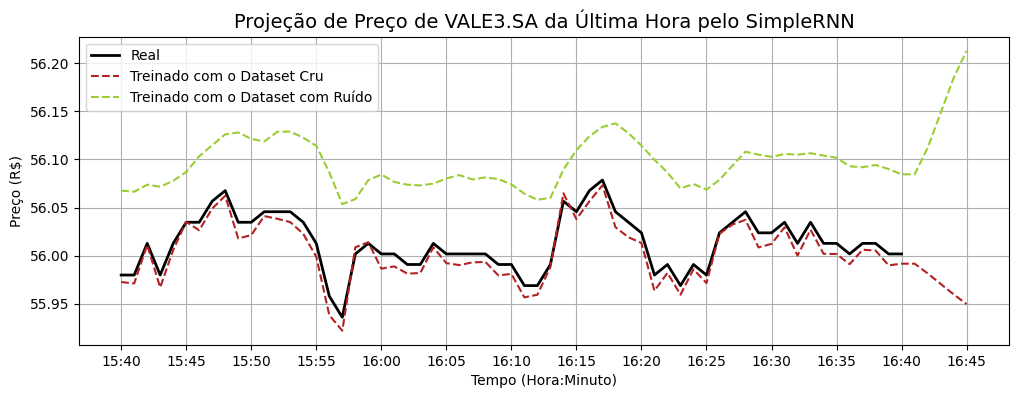

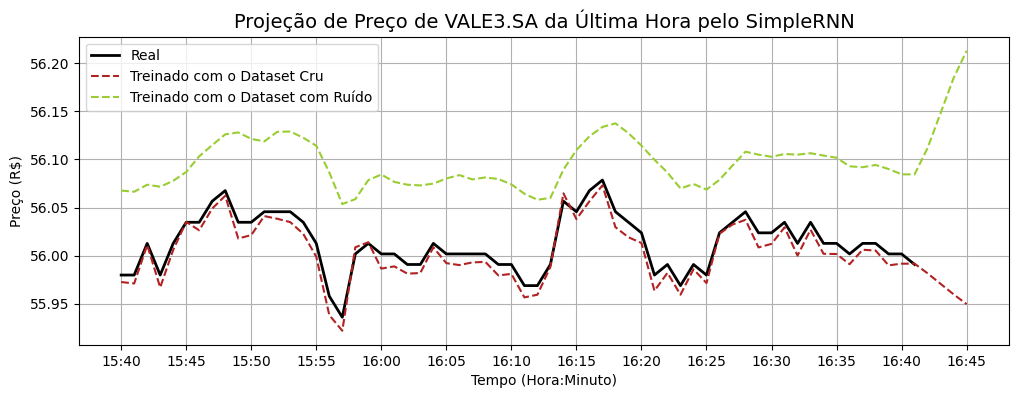

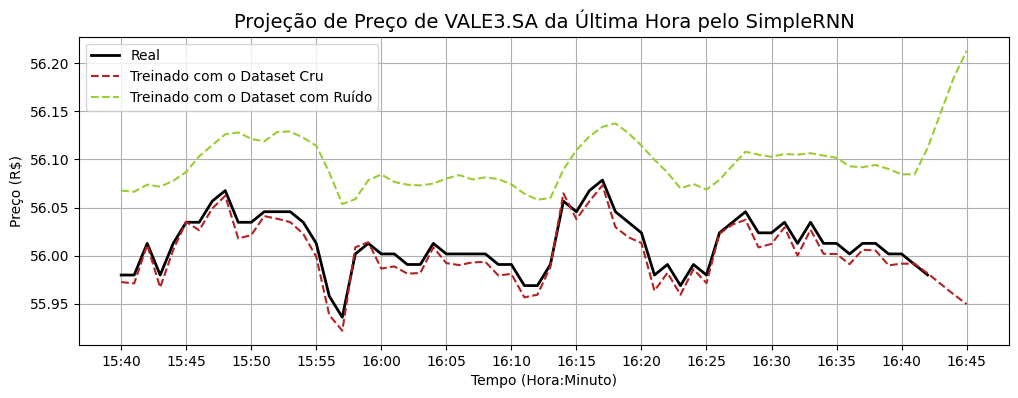

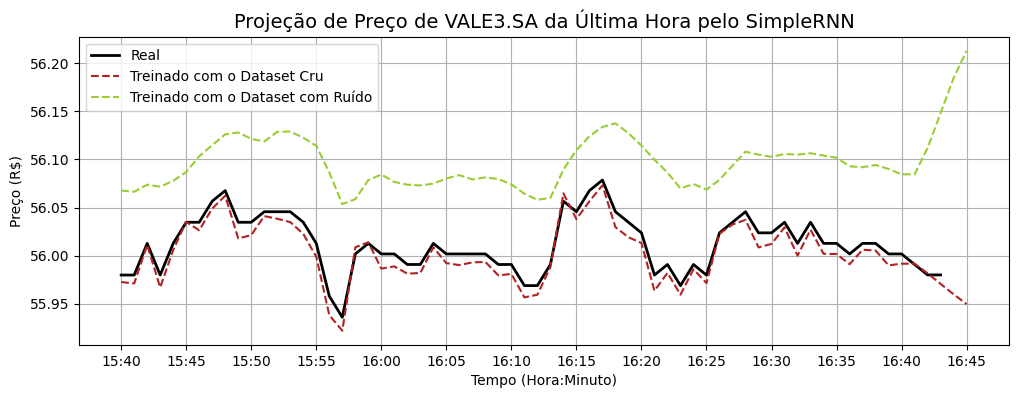

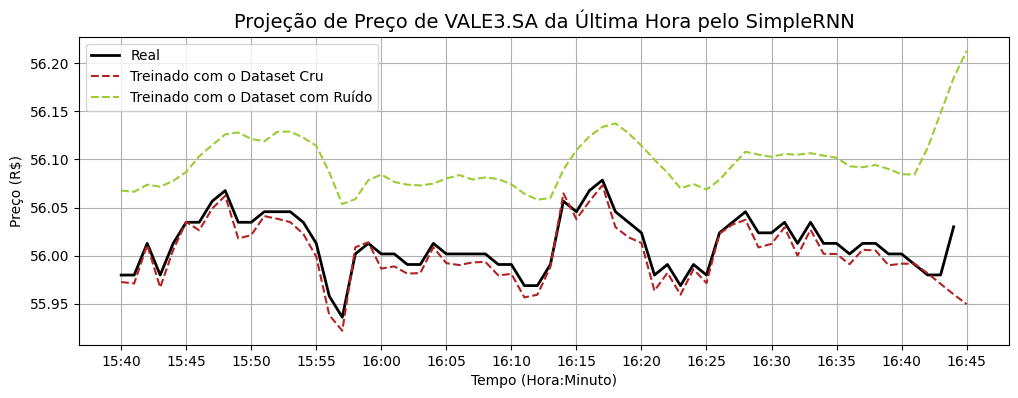

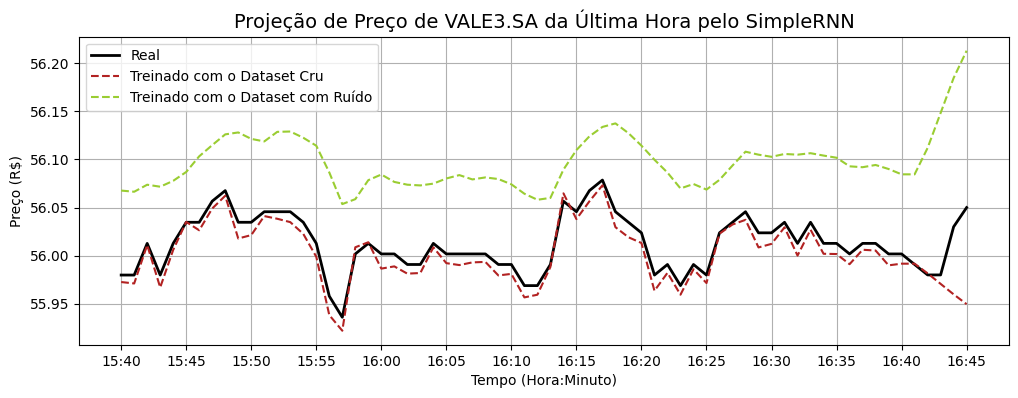

In [561]:
# -x- EXIBIÇÃO -x-
view = 60 # em minutos
tick_indices = range( 0, len( dt[ - view - 1 - n_minutos_frente : ] ), 5 )
tick_labels = list( datetimes[ - view - 1 - n_minutos_frente : : 5 ].strftime('%H:%M') )

for i in range( 0, n_minutos_frente + 1 ):
  plt.rcParams[ "figure.figsize" ] = ( 12, 4 )
  plt.plot( y_real[ - view - n_minutos_frente - 1 : len(y_real) - n_minutos_frente + i ], label = 'Real', linewidth = 2, color = 'black' )
  plt.plot( y_pred_raw[ - view - n_minutos_frente - 1 : ], label = 'Treinado com o Dataset Cru', linestyle = '--', color = 'firebrick' )
  plt.plot( y_pred_noise[ - view - n_minutos_frente - 1 : ], label = 'Treinado com o Dataset com Ruído', linestyle = '--', color = 'yellowgreen' )
  plt.title( f"Projeção de Preço de { acao } da Última Hora pelo SimpleRNN", fontsize = 14 )
  plt.xticks( tick_indices, tick_labels, rotation = 0 )
  plt.xlabel( "Tempo (Hora:Minuto)" )
  plt.ylabel( "Preço (R$)" )
  plt.legend()
  plt.grid( True )
  plt.show()

<br><hr>

<h4><strong>3. LSTM</strong></h4>
<a id="3"></a>

In [562]:
from sklearn.preprocessing import MinMaxScaler

# -x- FUNÇÃO PARA A CRIAÇÃO DAS JANELAS DESLIZANTES DE DADOS -x-
def create_dataset( series, janela = 10 ):
  X, y = [], []
  for i in range( 0, len( series ) - janela ):
    X.append( series[ i : i + janela ] )
    y.append( series[ i + janela ] )
  return np.array( X ), np.array( y )

# -x- CRIANDO E SEPARANDO OS DADOS DE TREINO/TESTE -x-
# Divisão treino/teste
train_size = int( 0.8 * len( data_raw ) )
train_data, test_data = data_raw[ : train_size ], data_raw[ train_size : ]
train_data_noise, _ = data_noise[ : train_size ], data_noise[ train_size : ]

# Normalização dos dados
scaler = MinMaxScaler( feature_range = ( 0, 1 ) )
train_data = scaler.fit_transform( train_data.reshape( -1, 1 ) )
test_data = scaler.transform( test_data.reshape( -1, 1 ) )
train_data_noise = scaler.fit_transform( train_data_noise.reshape( -1, 1 ) )

<h5><strong>3.1 Dataset Cru</strong><h5>
<a id="3.1"></a>
Após um GridSearch, chegamos aos parâmetros:
<br>
num_layers = 2
<br>
janela = 20
<br>
hidden1 = 128
<br>
hidden2 = 32
<br>
activation = relu
<br>
batch_size = 32

In [563]:
# -x- CRIAÇÃO DAS JANELAS -x-
window_size = 20
ws_raw = window_size
X_train, y_train = create_dataset( train_data_noise, window_size )
X_test, y_test = create_dataset( test_data, window_size )

In [564]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -x- CRIAÇÃO DO MODELO -x-
model_raw_LSTM = Sequential()
model_raw_LSTM.add( LSTM( units = 128, activation = "relu", return_sequences = True, input_shape = ( window_size, 1 ) ) )
model_raw_LSTM.add( LSTM( units = 32, activation = "relu" ) )
model_raw_LSTM.add( Dense( units = 1 ) )
model_raw_LSTM.compile( optimizer = "adam", loss = "mean_squared_error" )
# Treinamento do modelo
model_raw_LSTM.fit( X_train, y_train, epochs = 100, batch_size = 32, verbose = 0 )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [565]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -x- CALCULO DOS RESULTADOS -x-
# Previsões e inversão da normalização
y_pred_raw = scaler.inverse_transform( model_raw_LSTM.predict( X_test ) )
y_real = scaler.inverse_transform( y_test )

# Cálculo das métricas
mse_raw = mean_squared_error( y_real, y_pred_raw )
rmse_raw = np.sqrt( mse_raw )
mae_raw = mean_absolute_error( y_real, y_pred_raw )
r2_raw = r2_score( y_real, y_pred_raw )

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


<h5><strong>3.2 Dataset com Ruído</strong><h5>
<a id="3.2"></a>
Após um GridSearch, chegamos aos parâmetros:
<br>
num_layers = 2
<br>
janela = 20
<br>
hidden1 = 32
<br>
hidden2 = 128
<br>
activation = relu
<br>
batch_size = 16

In [566]:
# -x- CRIAÇÃO DAS JANELAS -x-
window_size = 20
ws_noise = window_size
X_train, y_train = create_dataset( train_data, window_size )
X_test, y_test = create_dataset( test_data, window_size )

In [567]:
# -x- CRIAÇÃO DO MODELO -x-
model_noise_LSTM = Sequential()
model_noise_LSTM.add( LSTM( units = 32, activation = "relu", return_sequences = True, input_shape = ( window_size, 1 ) ) )
model_noise_LSTM.add( LSTM( units = 128, activation = "relu" ) )
model_noise_LSTM.add( Dense( units = 1 ) )
model_noise_LSTM.compile( optimizer = "adam", loss = "mean_squared_error" )
# Treinamento do modelo
model_noise_LSTM.fit( X_train, y_train, epochs = 100, batch_size = 16, verbose = 0 )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [568]:
# -x- CALCULO DOS RESULTADOS -x-
# Previsões e inversão da normalização
y_pred_noise = scaler.inverse_transform( model_noise_LSTM.predict( X_test ) )
y_real = scaler.inverse_transform( y_test )
# Cálculo das métricas
mse_noise = mean_squared_error( y_real, y_pred_noise )
rmse_noise = np.sqrt( mse_noise )
mae_noise = mean_absolute_error( y_real, y_pred_noise )
r2_noise = r2_score( y_real, y_pred_noise )

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


<h5><strong>3.3 Resultados do Treino</strong><h5>
<a id="3.3"></a>

MÉTRICAS SimpleRNN
Dataset Cru
MSE  : 0.00358
RMSE : 0.05984
MAE  : 0.04702
R²   : 0.95787
Dataset com Ruído
MSE  : 0.00152
RMSE : 0.03892
MAE  : 0.02768
R²   : 0.98217


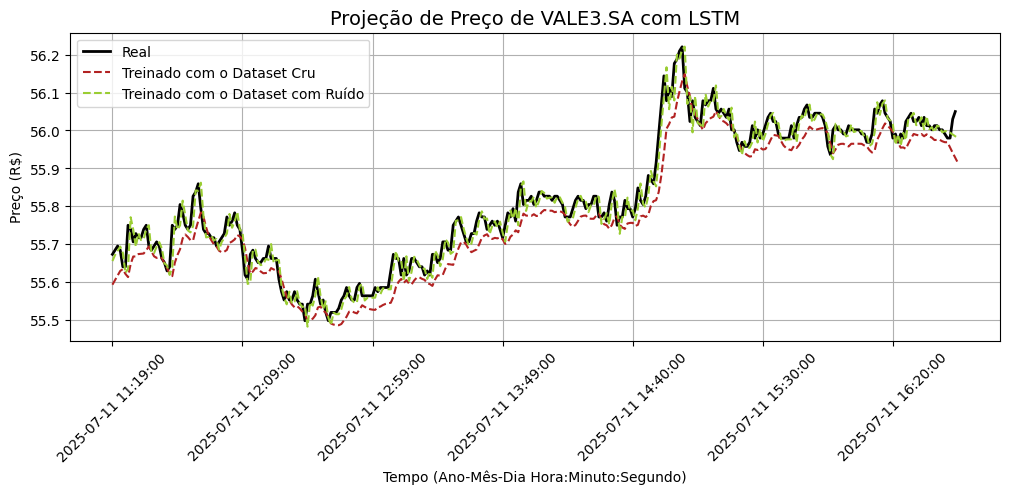

In [572]:
# -x- EXIBIÇÃO DOS RESULTADOS -x-
# Resultados numéricos
print( "MÉTRICAS SimpleRNN" )
print( "Dataset Cru" )
print( f"MSE  : {mse_raw:.5f}" )
print( f"RMSE : {rmse_raw:.5f}" )
print( f"MAE  : {mae_raw:.5f}" )
print( f"R²   : {r2_raw:.5f}" )
print( "Dataset com Ruído" )
print( f"MSE  : {mse_noise:.5f}" )
print( f"RMSE : {rmse_noise:.5f}" )
print( f"MAE  : {mae_noise:.5f}" )
print( f"R²   : {r2_noise:.5f}" )

# Visualização
janela_visualizacao = len(test_data)//2
plt.rcParams[ "figure.figsize" ] = ( 12, 4 )
tick_indices = range( 0, len( datetimes[ -janela_visualizacao - 1 : ] ), 50)
tick_labels = list( datetimes[ -janela_visualizacao - 1 : : 50] )
plt.plot( y_real[ - janela_visualizacao : ], label = 'Real', linewidth = 2, color = 'black' )
plt.plot( y_pred_raw[ - janela_visualizacao : ], label = 'Treinado com o Dataset Cru', linestyle = '--', color = 'firebrick' )
plt.plot( y_pred_noise[ - janela_visualizacao : ], label = 'Treinado com o Dataset com Ruído', linestyle = '--', color = 'yellowgreen' )
plt.title( f"Projeção de Preço de { acao } com LSTM", fontsize = 14 )
plt.xticks( tick_indices, tick_labels, rotation = 45 )
plt.xlabel( "Tempo (Ano-Mês-Dia Hora:Minuto:Segundo)" )
plt.ylabel( "Preço (R$)" )
plt.legend()
plt.grid( True )
plt.show()

<h5><strong>3.4 Predição em Tempo Real</strong><h5>
<a id="3.4"></a>

In [570]:
# -x- PREDIÇÃO DOS PROXIMOS MINUTOS -x-
X_test_raw, _ = create_dataset( test_data, ws_raw )
X_test_noise, _ = create_dataset( test_data, ws_noise )
pred_norm_raw = list()
pred_norm_noise = list()
x_input_raw = X_test_raw[ -1 ].reshape(1, ws_raw, 1)
x_input_noise = X_test_noise[ -1 ].reshape(1, ws_noise, 1)

for i in range( 0, n_minutos_frente ):
  aux_pred_norm_raw = model_raw_LSTM.predict( x_input_raw, verbose = 0 )
  pred_norm_raw.append( aux_pred_norm_raw[ 0, 0 ] )
  next_input_norm_raw = np.append( x_input_raw[ 0, 1:, 0 ], aux_pred_norm_raw[ 0, 0 ] )
  x_input_raw = next_input_norm_raw.reshape( 1, ws_raw, 1 )

  aux_pred_norm_noise = model_noise_LSTM.predict( x_input_noise, verbose = 0 )
  pred_norm_noise.append( aux_pred_norm_noise[ 0, 0 ] )
  next_input_norm_noise = np.append( x_input_noise[ 0, 1:, 0 ], aux_pred_norm_noise[ 0, 0 ] )
  x_input_noise = next_input_norm_noise.reshape(1, ws_noise, 1)

y_real = np.append( y_real, data[ index_5m + 1 : index_5m + 5 ] )

pred_raw = scaler.inverse_transform( np.array( pred_norm_raw ).reshape( -1, 1 ) )
y_pred_raw = np.append( y_pred_raw, pred_raw )

pred_noise = scaler.inverse_transform( np.array( pred_norm_noise ).reshape( -1, 1 ) )
y_pred_noise = np.append( y_pred_noise, pred_noise )

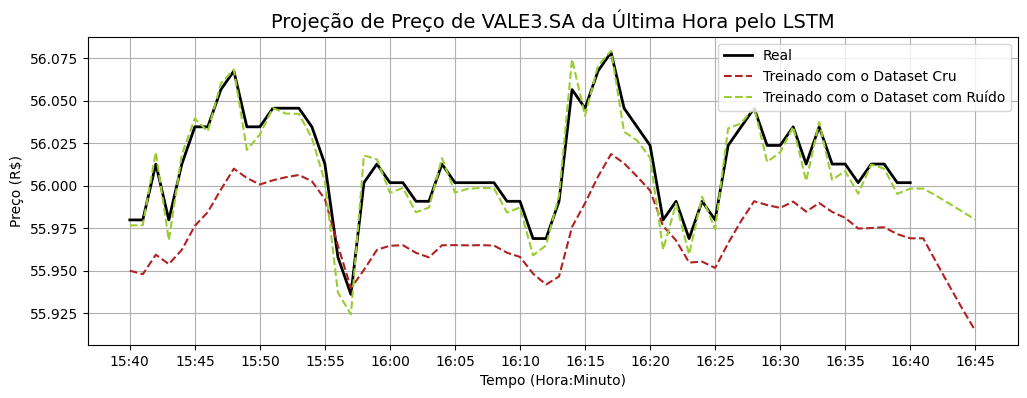

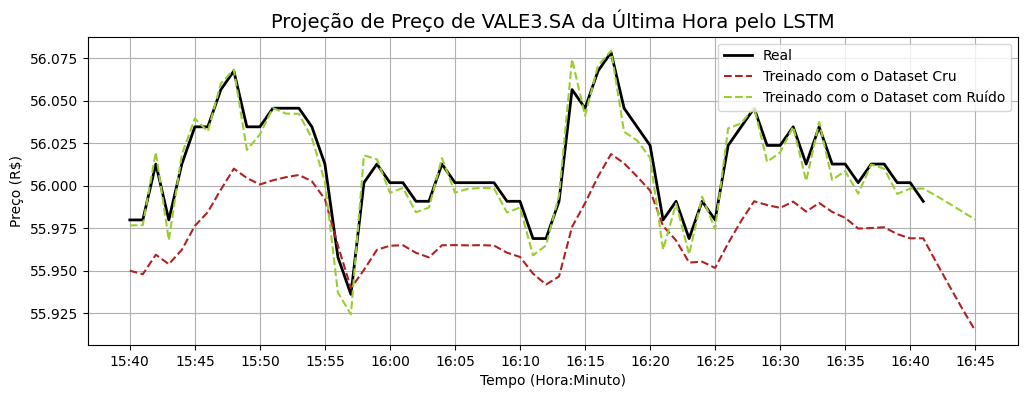

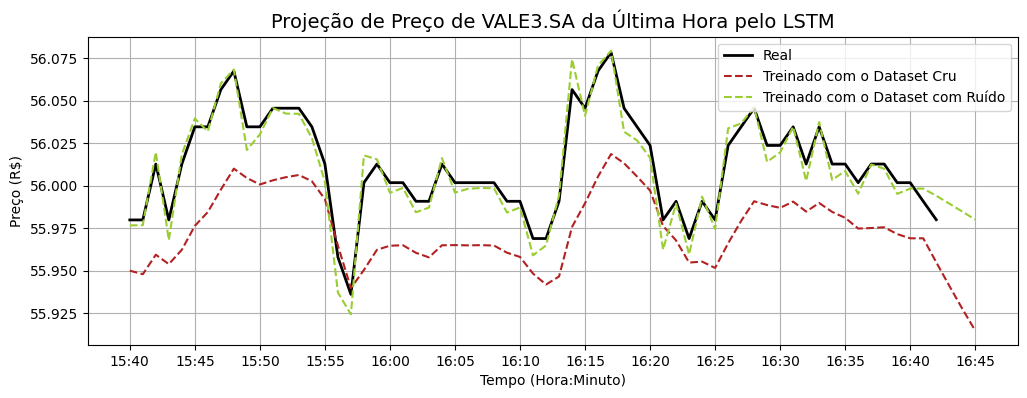

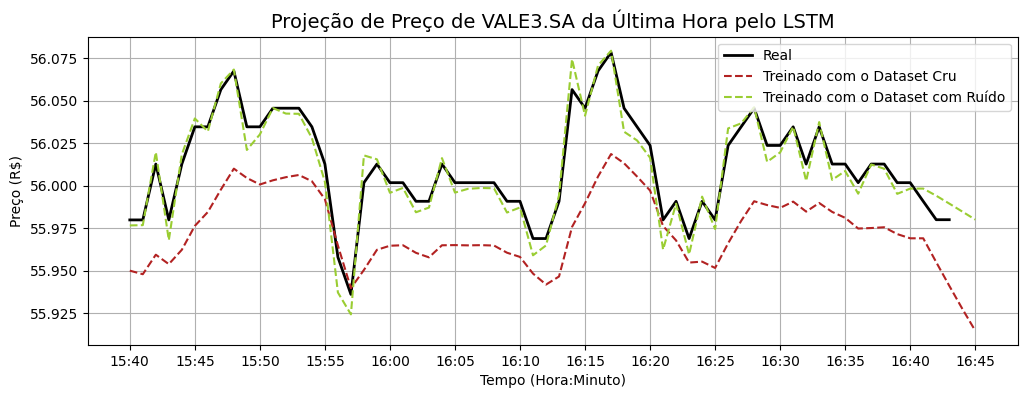

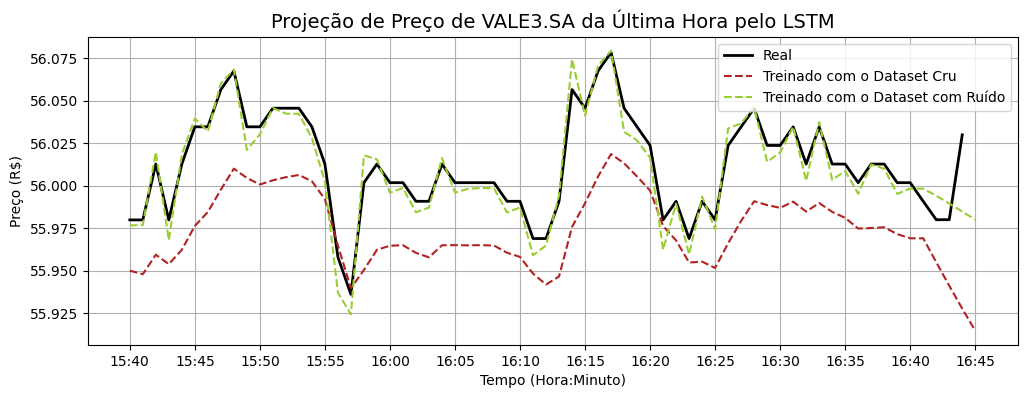

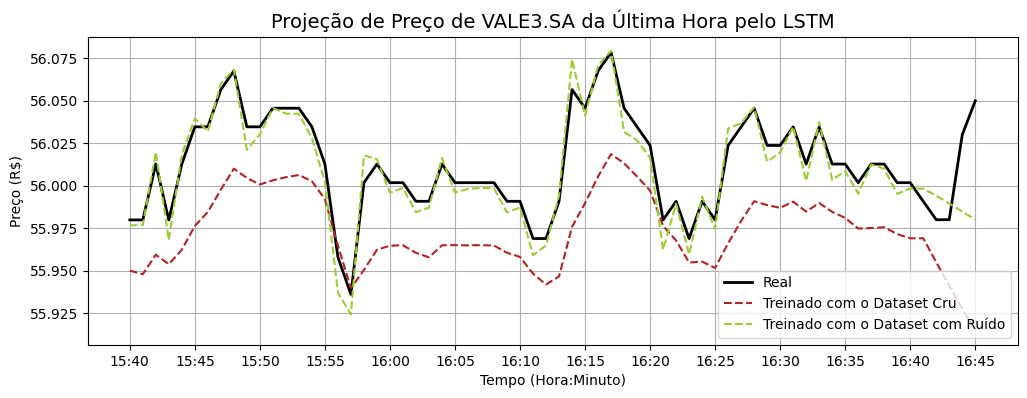

In [571]:
# -x- EXIBIÇÃO -x-
view = 60 # em minutos
tick_indices = range( 0, len( dt[ - view - 1 - n_minutos_frente : ] ), 5 )
tick_labels = list( datetimes[ - view - 1 - n_minutos_frente : : 5 ].strftime('%H:%M') )

for i in range( 0, n_minutos_frente + 1 ):
  plt.rcParams[ "figure.figsize" ] = ( 12, 4 )
  plt.plot( y_real[ - view - n_minutos_frente - 1 : len(y_real) - n_minutos_frente + i ], label = 'Real', linewidth = 2, color = 'black' )
  plt.plot( y_pred_raw[ - view - n_minutos_frente - 1 : ], label = 'Treinado com o Dataset Cru', linestyle = '--', color = 'firebrick' )
  plt.plot( y_pred_noise[ - view - n_minutos_frente - 1 : ], label = 'Treinado com o Dataset com Ruído', linestyle = '--', color = 'yellowgreen' )
  plt.title( f"Projeção de Preço de { acao } da Última Hora pelo LSTM", fontsize = 14 )
  plt.xticks( tick_indices, tick_labels, rotation = 0 )
  plt.xlabel( "Tempo (Hora:Minuto)" )
  plt.ylabel( "Preço (R$)" )
  plt.legend()
  plt.grid( True )
  plt.show()